In [138]:
import os
import importlib
import numpy as np
import yaml
from tqdm.auto import tqdm
import seesaw
import ray 
import seesaw.seesaw_bench
import seesaw.figures
import seesaw.dataset_manager
import seesaw.dataset

importlib.reload(seesaw.dataset)
importlib.reload(seesaw.dataset_manager)
importlib.reload(seesaw.seesaw_bench)
importlib.reload(seesaw.metrics)
importlib.reload(seesaw.figures)
importlib.reload(seesaw.seesaw_bench)

from seesaw.seesaw_bench import *
from seesaw.figures import *
from plotnine import *
from seesaw.dataset_manager import GlobalDataManager
import seesaw.figure_utils
importlib.reload(seesaw.figure_utils)
from seesaw.figure_utils import *

In [156]:
eval_data = pd.read_parquet('../figures/eval_data.parquet')

In [158]:
#eval_data.category

In [ ]:
### first data for overall eval

In [159]:
#base_cols =  ['param_hash' 'timestamp', 'dataset']
detail_cols = ['index_name', 'start_policy', 'variant', 'calibration', 'reward_horizon', 'pos_weight', 'reg_data_lambda', 'reg_query_lambda', 'reg_norm_lambda', ]

In [160]:
display_means(eval_data, other_cols=detail_cols, metric='average_precision')

dataset,index_name,start_policy,variant,calibration,reward_horizon,pos_weight,reg_data_lambda,reg_query_lambda,reg_norm_lambda,param_hash,timestamp,bdd,coco,lvis,objectnet,average
0,multiscalecoarse,after_first_batch,active_search,ground_truth,1.00,nan,nan,nan,nan,a3d1e64b,2023-03-17 18:06:03,0.72,0.93,0.66,0.65,0.74
1,multiscalecoarse,after_first_batch,active_search,ground_truth,2.00,nan,nan,nan,nan,f165d96a,2023-03-17 18:06:03,0.73,0.93,0.66,0.66,0.74
2,multiscalecoarse,after_first_batch,active_search,ground_truth,10.00,nan,nan,nan,nan,66719f9c,2023-03-17 18:06:03,0.70,0.94,0.65,0.67,0.74
3,multiscalecoarse,after_first_batch,active_search,ground_truth,60.00,nan,nan,nan,nan,ec7a1d44,2023-03-17 18:06:03,0.74,0.93,0.59,0.63,0.72
4,multiscalecoarse,after_first_batch,active_search,raw,1.00,nan,nan,nan,nan,3c2757c0,2023-03-17 18:06:03,0.70,0.90,0.64,0.62,0.72
5,multiscalecoarse,after_first_batch,active_search,raw,2.00,nan,nan,nan,nan,07c3313d,2023-03-17 18:06:03,0.69,0.89,0.64,0.62,0.71
6,multiscalecoarse,after_first_batch,active_search,raw,10.00,nan,nan,nan,nan,b9cdd550,2023-03-17 18:06:03,0.70,0.89,0.60,0.60,0.70
7,multiscalecoarse,after_first_batch,active_search,raw,60.00,nan,nan,nan,nan,386d9ea5,2023-03-17 18:06:03,0.70,0.86,0.50,0.43,0.62
8,multiscalecoarse,after_first_batch,multi_reg,nan,nan,balanced,0.00,0.00,100.00,45632884,2023-03-15 17:42:10,0.72,0.88,0.65,0.59,0.71
9,multiscalecoarse,after_first_batch,multi_reg,nan,nan,balanced,0.00,10.00,100.00,a3925409,2023-03-15 17:42:10,0.75,0.92,0.68,0.69,0.76


In [511]:
def add_hard_queries(eval_data):
    baseline_df = eval_data[eval_data.full_hash.eq('2501cb92_multiscalecoarse')]
    hard_baseline_df = baseline_df[baseline_df.average_precision < .5]
    hard_queries_df = hard_baseline_df[['dataset', 'category']].sort_values(['dataset', 'category']).reset_index(drop=True)
    eval_hard_df = eval_data.merge(hard_queries_df, left_on=('dataset', 'category'), right_on=('dataset', 'category'), how='right')

        
    eval_hard_df = eval_hard_df.assign(query_group='hard subset')
    eval_df = eval_data.assign(query_group='all queries')
    
    full_df = pd.concat([eval_df, eval_hard_df], ignore_index=True).reset_index(drop=True)
    full_df = full_df.assign(**{'query group':pd.Categorical(full_df.query_group, categories=['all queries', 'hard subset'], ordered=True)})
    
    return full_df

In [523]:
stats2 = add_hard_queries(eval_data)
# stats2.groupby(['query_group', 'dataset', 'full_hash']).size().unstack('dataset')
dataset_names = {
    'lvis':'LVIS',
    'objectnet':'ObjNet',
    'coco':'COCO',
    'bdd':'BDD',
    'Avg.':'Avg.', # used for ordering. 
}
stats2 = stats2.assign(dataset=pd.Categorical(stats2.dataset.map(lambda x : dataset_names[x]), categories=dataset_names.values(), ordered=True))

In [387]:
## goal: decide what results tables will look like. 

## option 

### option 1: skip multiscale altogether.
# benefit: avoids need to explain multiscale. easy to compare with other existing approaches.
# shortcoming: thins out contribution list. user study and system description make less sense in this case.

### option 2: include multiscale only for some evaluation sections. 
## start with an overall section that compares all techniques. 
## can have with and without multiscale to include ENS, but also to introduce the results.

### Problem 1: absolute aggregate improvements can seem small. this needs to be addressed early.
# we need to show them for less common queries
## by dataset, by query hardness, by method is a lot of data.
## why is by dataset needed? to show generality.

### approach
# 1. results compared to baseline as before, but introduce good results before. this can be done with relative improvement.

# 2. now compare against ENS and Log Reg. without necessarily doing that breakdown, as we have established the small numbers are ok.

## 2.2 break-down ENS performance partly to explain results.

# 3. now break down seesaw optimization benefits. no need to break them down unless some stuff shows no benefit in one subset.

# 4. user study.



In [417]:
stats2.groupby(['variant', 'calibration', 'reward_horizon', 'full_hash'], dropna=False).size()

variant        calibration   reward_horizon  full_hash                
active_search  ground_truth  1.0             a3d1e64b_multiscalecoarse    2174
                             2.0             f165d96a_multiscalecoarse    2174
                             10.0            66719f9c_multiscalecoarse    2174
                             60.0            ec7a1d44_multiscalecoarse    2174
               raw           1.0             3c2757c0_multiscalecoarse    2174
                             2.0             07c3313d_multiscalecoarse    2174
                             10.0            b9cdd550_multiscalecoarse    2174
                             60.0            386d9ea5_multiscalecoarse    2174
baseline       NaN           NaN             2501cb92_multiscalecoarse    2174
                                             2501cb92_multiscalemed       2174
multi_reg      NaN           NaN             0ddf1e42_multiscalecoarse    2174
                                             0ddf1e42_multis

In [543]:
def gen_main_comparison_table(stats2, metric='average_precision'):
    """compare the high level strategies without a benefit breakdown"""
    
    table_variant_names = {
                '2501cb92_multiscalecoarse':'CLIP alone',
        #  active search no calibration. reward horizon 60
                '386d9ea5_multiscalecoarse':'ENS', 
                'eda85ef1_multiscalecoarse':'this work (- multiscale)',
                'eda85ef1_multiscalemed': 'this work',
    }
    
    breakdown_df = stats2[stats2.full_hash.isin(table_variant_names.keys())] #[compare_subset.easy_full_variant_name.isin(breakdown_variants)]
    
    # print(breakdown_df.full_hash.unique())
    breakdown_df = breakdown_df.assign(method = breakdown_df.full_hash.map(lambda x : table_variant_names[x]))
    breakdown_df = breakdown_df.assign(method = pd.Categorical(breakdown_df.method, categories=list(table_variant_names.values()), ordered=True))

    breakdown_df = breakdown_df[['query group','method', 'category', 'param_hash', 'index_name', 'dataset', metric]]    
    aggs = breakdown_df.groupby(['query group', 'method','dataset'], dropna=True)[metric].mean().rename('average_precision')
    
    avg = aggs.reset_index().assign(dataset='Avg.').groupby(['query group', 'method', 'dataset'], dropna=True)[metric].mean()
    
    aggs = pd.concat([aggs, avg])
    aggs = aggs.sort_index().dropna()
    
    return aggs

In [446]:
#stats2[stats2.full_hash.isin(['2501cb92_multiscalecoarse'])]

In [544]:
gen_main_comparison_table(stats2)

query group  method                    dataset
all queries  CLIP alone                LVIS       0.625204
                                       ObjNet     0.635007
                                       COCO       0.896128
                                       BDD        0.741339
                                       Avg.       0.724420
             ENS                       LVIS       0.501479
                                       ObjNet     0.429477
                                       COCO       0.862546
                                       BDD        0.696917
                                       Avg.       0.622605
             this work (- multiscale)  LVIS       0.685640
                                       ObjNet     0.701285
                                       COCO       0.923996
                                       BDD        0.758466
                                       Avg.       0.767347
             this work                 LVIS       0.758958
         

In [545]:
tab = gen_main_comparison_table(stats2).unstack('method')

with pd.option_context('display.float_format', '{:.02f}'.format):
    display(tab)

method               CLIP alone  ENS  this work (- multiscale)  this work
query group dataset                                                      
all queries LVIS           0.63 0.50                      0.69       0.76
            ObjNet         0.64 0.43                      0.70       0.70
            COCO           0.90 0.86                      0.92       0.96
            BDD            0.74 0.70                      0.76       0.79
            Avg.           0.72 0.62                      0.77       0.80
hard subset LVIS           0.19 0.16                      0.30       0.44
            ObjNet         0.28 0.24                      0.40       0.40
            COCO           0.27 0.37                      0.55       0.75
            BDD            0.02 0.03                      0.07       0.24
            Avg.           0.19 0.20                      0.33       0.46

In [546]:
print(tab.style.format(precision=2).to_latex(label='tab:main',hrules=True, clines='all;index', caption='Table comparing \sys/ to baselines'))

\begin{table}
\caption{Table comparing \sys/ to baselines}
\label{tab:main}
\begin{tabular}{llrrrr}
\toprule
 & method & CLIP alone & ENS & this work (- multiscale) & this work \\
query group & dataset &  &  &  &  \\
\midrule
\multirow[c]{5}{*}{all queries} & LVIS & 0.63 & 0.50 & 0.69 & 0.76 \\
\cline{2-2}
 & ObjNet & 0.64 & 0.43 & 0.70 & 0.70 \\
\cline{2-2}
 & COCO & 0.90 & 0.86 & 0.92 & 0.96 \\
\cline{2-2}
 & BDD & 0.74 & 0.70 & 0.76 & 0.79 \\
\cline{2-2}
 & Avg. & 0.72 & 0.62 & 0.77 & 0.80 \\
\cline{1-2} \cline{2-2}
\multirow[c]{5}{*}{hard subset} & LVIS & 0.19 & 0.16 & 0.30 & 0.44 \\
\cline{2-2}
 & ObjNet & 0.28 & 0.24 & 0.40 & 0.40 \\
\cline{2-2}
 & COCO & 0.27 & 0.37 & 0.55 & 0.75 \\
\cline{2-2}
 & BDD & 0.02 & 0.03 & 0.07 & 0.24 \\
\cline{2-2}
 & Avg. & 0.19 & 0.20 & 0.33 & 0.46 \\
\cline{1-2} \cline{2-2}
\bottomrule
\end{tabular}
\end{table}



In [547]:
def gen_seesaw_breakdown_table(stats2):
        
    # baseline                        2501cb92_multiscalecoarse    1608
    #                                 2501cb92_multiscalemed       1608
    # lr_norm_and_data_reg            0ddf1e42_multiscalecoarse    1608
    #                                 0ddf1e42_multiscalemed       1608
    # lr_norm_and_query_and_data_reg  eda85ef1_multiscalecoarse    1608
    #                                 eda85ef1_multiscalemed       1608
    # lr_norm_and_query_reg           2c32d711_multiscalemed       1608
    #                                 a3925409_multiscalecoarse    1608
    # lr_norm_reg                     45632884_multiscalecoarse    1608
    #                                 56d7a279_multiscalemed       1608

#    easy_name_map = {k:v for (v,k) in easy_names}
    
    
    subset = stats2[stats2.param_hash.isin(easy_name_map.keys())]
    subset = subset.assign(easy_variant_name=subset.param_hash.map(lambda phash : easy_name_map[phash]))
    subset = (subset.assign(easy_full_variant_name=compare_subset[['easy_variant_name', 'index_name']]
                           .apply(tuple, axis=1).map(lambda tup: f'{tup[1]}_{tup[0]}')))

    # previous version.
    # table_variant_names = {
    #                       '2501cb92_multiscalecoarse':'CLIP alone', 
    #                       'a3925409_multiscalecoarse': '+ CLIP alignment objective', 
    #                       'eda85ef1_multiscalecoarse': '+ DB alignment objective',
    #                       'eda85ef1_multiscalemed': '+ multiscale representation',
    # }
    
    table_variant_names = { 
                            '2501cb92_multiscalecoarse':'CLIP alone', 
                            '2501cb92_multiscalemed':'+ multiscale representation',
                            '56d7a279_multiscalemed':'+ logistic reg. on feedback',
                            '2c32d711_multiscalemed':'+ CLIP alignment objective',
                            'eda85ef1_multiscalemed':'+ DB alignment objective',
    }
    
    # alternative ordering
    # table_variant_names = {
    #                       'multiscalecoarse_baseline':'CLIP alone', 
    #                       'multiscalemed_baseline': '+ multi-scale representation', 
    #                       'multiscalemed_lr_norm_and_query_reg': '+ CLIP alignment objective', 
    #                       'multiscalemed_lr_norm_and_query_and_data_reg': '+ DB alignment objective',
    # }    
    breakdown_df = subset[subset.full_hash.isin(table_variant_names.keys())]
    breakdown_df = breakdown_df.assign(method = breakdown_df.full_hash.map(lambda x : table_variant_names[x]))
    breakdown_df = breakdown_df.assign(method=pd.Categorical(breakdown_df.method, categories=table_variant_names.values(), ordered=True))
    
    agg = breakdown_df.groupby(['query group', 'method', 'dataset'], observed=True).average_precision.mean()
    
    avg = agg.reset_index().assign(dataset='Avg.').groupby(['query group', 'method', 'dataset'], observed=True).average_precision.mean()
    
    agg = pd.concat([agg, avg]).sort_index()
    
    return agg

In [551]:
tab_breakdown= gen_seesaw_breakdown_table(stats2)

with pd.option_context('display.float_format', '{:.02f}'.format):
    display(tab_breakdown.unstack('dataset'))

dataset                                  LVIS  ObjNet  COCO  BDD  Avg.
query group method                                                    
all queries CLIP alone                   0.63    0.64  0.90 0.74  0.72
            + multiscale representation  0.70    0.64  0.95 0.76  0.76
            + logistic reg. on feedback  0.67    0.59  0.87 0.68  0.70
            + CLIP alignment objective   0.75    0.69  0.96 0.77  0.79
            + DB alignment objective     0.76    0.70  0.96 0.79  0.80
hard subset CLIP alone                   0.19    0.28  0.27 0.02  0.19
            + multiscale representation  0.32    0.28  0.58 0.10  0.32
            + logistic reg. on feedback  0.34    0.28  0.57 0.07  0.31
            + CLIP alignment objective   0.42    0.39  0.74 0.20  0.44
            + DB alignment objective     0.44    0.40  0.75 0.24  0.46

In [555]:
#tab_breakdown.reset_index().to_parquet('../figures/breakdown_df.parquet')

In [549]:
print(tab_breakdown.unstack('dataset').style.format(precision=2)
        .to_latex(label='tab:breakdown', hrules=True, clines='all;index', caption='Table breaking down contributions'))

\begin{table}
\caption{Table breaking down contributions}
\label{tab:breakdown}
\begin{tabular}{llrrrrr}
\toprule
 & dataset & LVIS & ObjNet & COCO & BDD & Avg. \\
query group & method &  &  &  &  &  \\
\midrule
\multirow[c]{5}{*}{all queries} & CLIP alone & 0.63 & 0.64 & 0.90 & 0.74 & 0.72 \\
\cline{2-2}
 & + multiscale representation & 0.70 & 0.64 & 0.95 & 0.76 & 0.76 \\
\cline{2-2}
 & + logistic reg. on feedback & 0.67 & 0.59 & 0.87 & 0.68 & 0.70 \\
\cline{2-2}
 & + CLIP alignment objective & 0.75 & 0.69 & 0.96 & 0.77 & 0.79 \\
\cline{2-2}
 & + DB alignment objective & 0.76 & 0.70 & 0.96 & 0.79 & 0.80 \\
\cline{1-2} \cline{2-2}
\multirow[c]{5}{*}{hard subset} & CLIP alone & 0.19 & 0.28 & 0.27 & 0.02 & 0.19 \\
\cline{2-2}
 & + multiscale representation & 0.32 & 0.28 & 0.58 & 0.10 & 0.32 \\
\cline{2-2}
 & + logistic reg. on feedback & 0.34 & 0.28 & 0.57 & 0.07 & 0.31 \\
\cline{2-2}
 & + CLIP alignment objective & 0.42 & 0.39 & 0.74 & 0.20 & 0.44 \\
\cline{2-2}
 & + DB alignment object

In [463]:
# def breakdown_ens_error(stats2):
#     ''' explain what happens to ENS'''
#     pass

In [ ]:
eval_data.

In [458]:
eval_data[eval_data.variant  == 'active_search'].groupby(['calibration', 'reward_horizon', 'dataset'])
            .average_precision.mean().unstack('reward_horizon')

reward_horizon              1.0       2.0       10.0      60.0
calibration  dataset                                          
ground_truth bdd        0.721939  0.725764  0.702100  0.735866
             coco       0.934889  0.930622  0.937342  0.934026
             lvis       0.657933  0.656645  0.650317  0.590621
             objectnet  0.652595  0.663912  0.672224  0.628416
raw          bdd        0.699002  0.693527  0.695996  0.696917
             coco       0.900850  0.886284  0.886254  0.862546
             lvis       0.639441  0.635774  0.604178  0.501479
             objectnet  0.623185  0.620093  0.601890  0.429477

dataset                                       bdd      coco      lvis  \
query_group method                                                      
all queries CLIP alone                   0.741339  0.896128  0.625204   
            + CLIP alignment objective   0.748806  0.918779  0.676580   
            + DB alignment objective     0.758466  0.923996  0.685640   
            + multiscale representation  0.794440  0.960736  0.758958   
hard subset CLIP alone                   0.021126  0.271905  0.187418   
            + CLIP alignment objective   0.050994  0.505400  0.283984   
            + DB alignment objective     0.066700  0.548288  0.300582   
            + multiscale representation  0.238571  0.745484  0.444909   

dataset                                  objectnet  
query_group method                                  
all queries CLIP alone                    0.635007  
            + CLIP alignment objective    0.686238  
            + DB alignment objective      0.701285  
            + multiscale representation   0.701310  
hard subset CLIP alone                    0.277259  
            + CLIP alignment objective    0.387779  
            + DB alignment objective      0.398792  
            + multiscale representation   0.398874

In [92]:
breakdown_df.to_parquet('../figures/breakdown_df.parquet')

In [61]:
reduced_stats = stats[stats.full_hash.isin(variant_map.values())]
reduced_stats = reduced_stats.assign(variant_name=reduced_stats.full_hash.map(lambda x : variant_map_inv[x]))

In [64]:
method_comp = reduced_stats.pivot(index=['dataset', 'category'], columns=['variant_name'], values='average_precision',).reset_index()

In [67]:
method_comp.to_parquet('../seesaw_notebooks/main_results_scatter.parquet')

In [48]:
#mc = method_comp[method_comp.index_name == 'multiscalemed']

In [50]:
#method_comp.index_name.unique()

,greater,close,smaller,bothINF,methodNA,bothNA,refNA,total,methodINF,refINF
dataset,,,,,,,,,,
bdd,4,6,2,0,0,0,0,12,0,0
coco,17,52,11,0,0,0,0,80,0,0
lvis,568,457,178,0,0,0,0,1203,0,0
objectnet,199,72,42,0,0,0,0,313,0,0


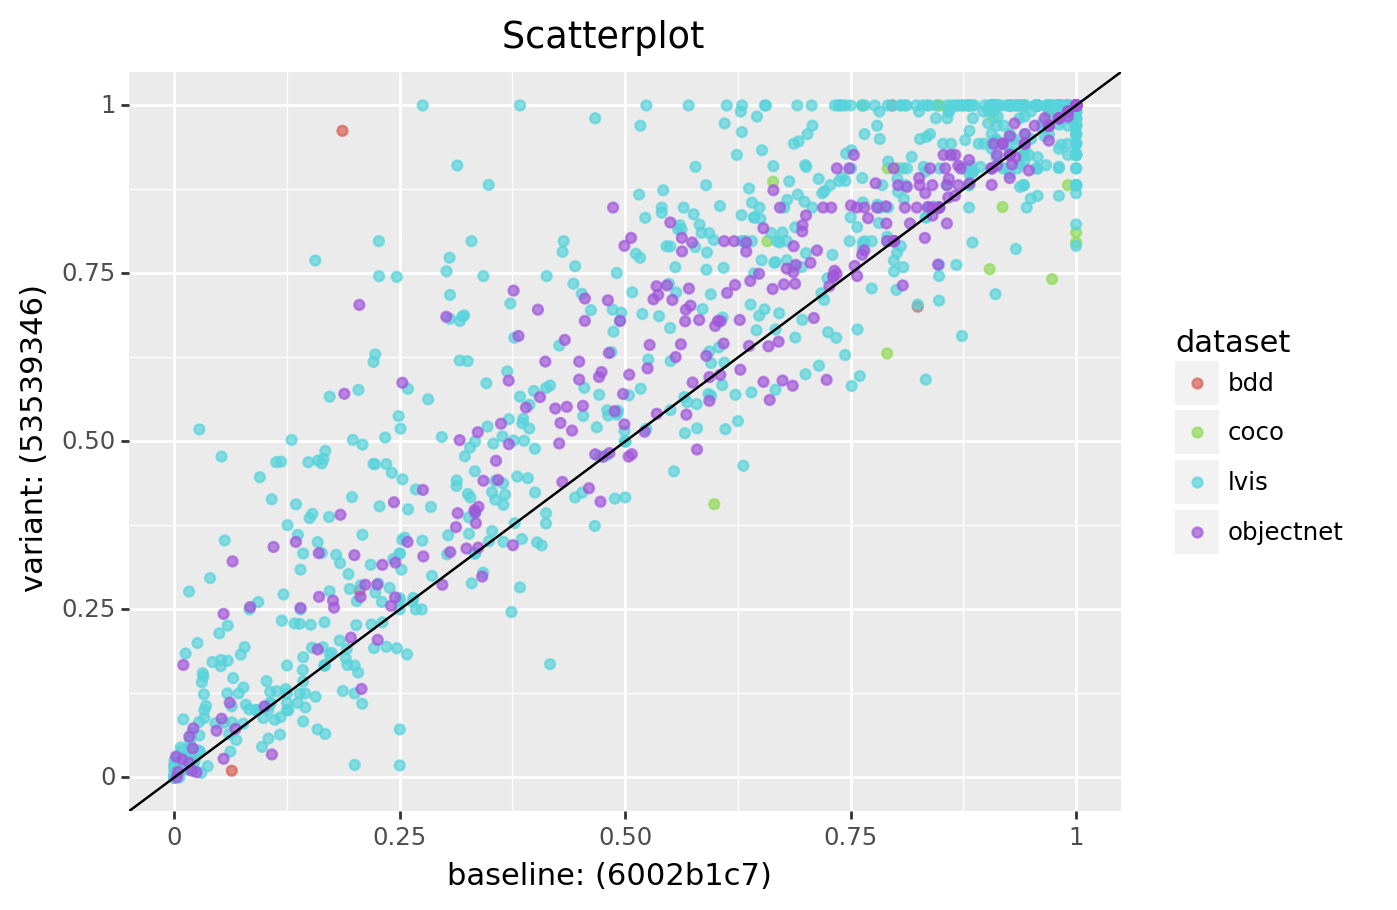

<ggplot: (8771774809366)>

/state/partition1/user/omoll/miniconda3/envs/seesaw/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/state/partition1/user/omoll/miniconda3/envs/seesaw/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 8 rows containing missing values.


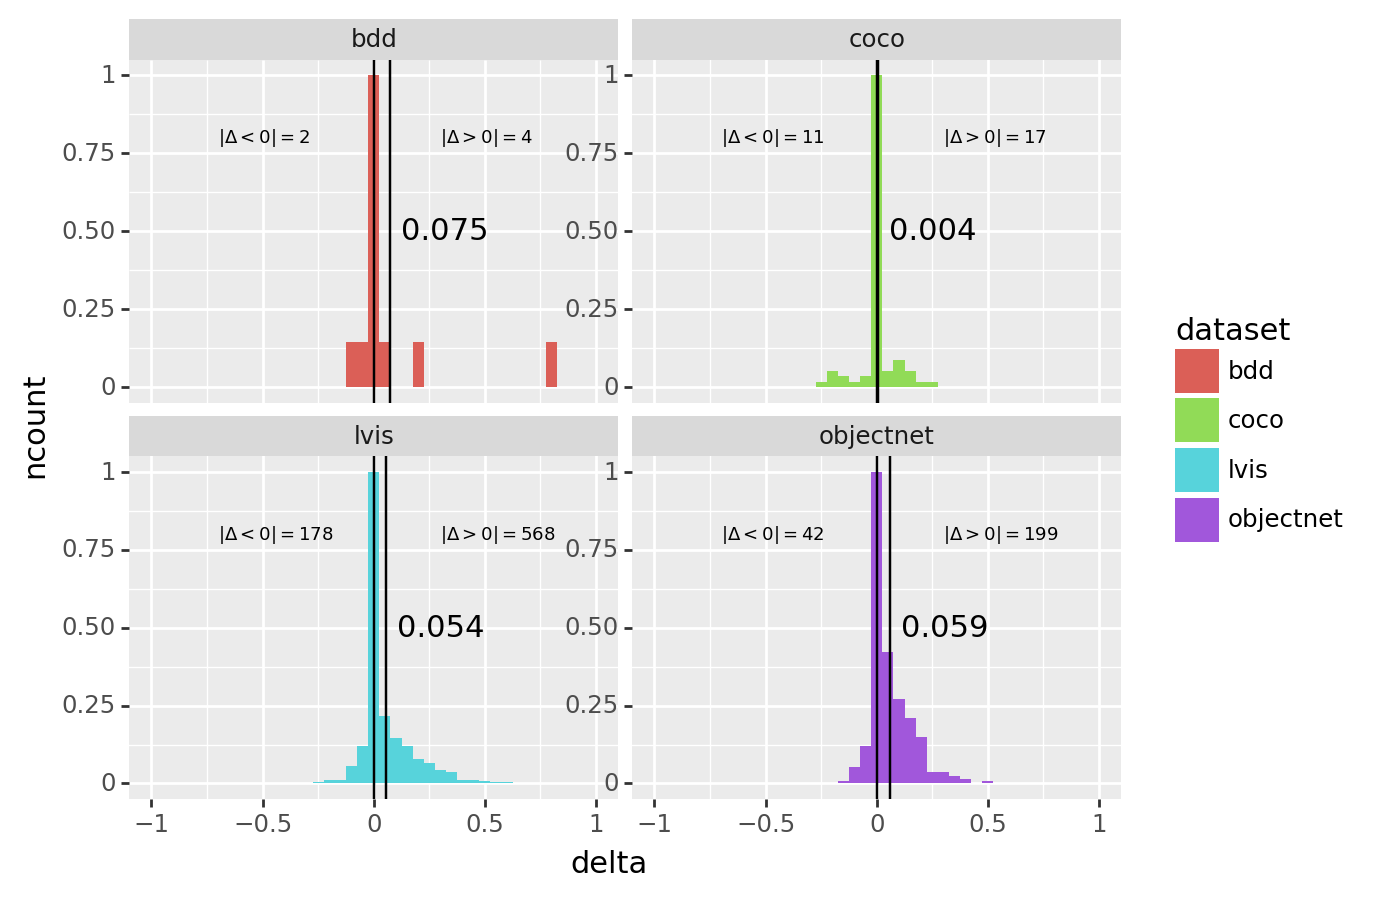

<ggplot: (8771774819157)>

In [37]:
scatter, deltahist = plot_compare2(method_comp, variant_col=variant_map['pseudo_lr'], baseline_col=variant_map['baseline'])

In [40]:
scatter.data.to_parquet('/state/partition1/user/omoll/seesaw/figures/query_scatter_multiscale.parquet')